In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt

/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, 

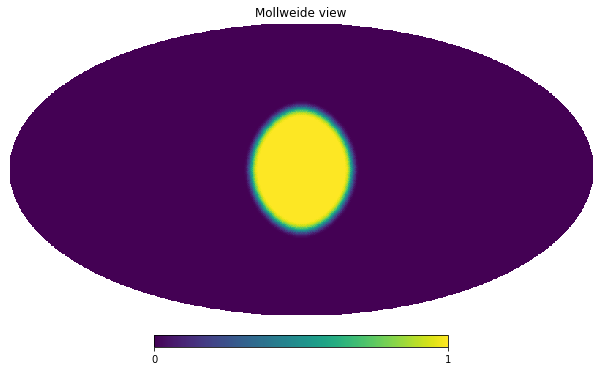

In [12]:
nsim = 100

nside = 128
mask = np.zeros(hp.nside2npix(nside))
th, ph = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))

ph[np.where(ph > np.pi)[0]] -= 2 * np.pi

mask[np.where(np.sqrt(ph**2+((th-np.pi/2)/1)**2)<np.pi/5)[0]] = 1.
msk_apo = nmt.mask_apodization(mask, 10, apotype='C1')

hp.mollview(msk_apo)

In [13]:
b = nmt.NmtBin.from_nside_linear(nside, 32)
leff = b.get_effective_ells()
l, cltt, clee, clbb, clte = np.loadtxt('totcls_r001.txt', unpack=True)
cl_th = np.array([clee, np.zeros_like(clee), np.zeros_like(clee), clbb])


In [14]:
def get_fields(i):
    mp_t, mp_q, mp_u = hp.read_map(f'./input_maps/map_{i}.fits', field=[0,1,2], verbose=False, dtype=np.float64)
    
    # This creates a spin-2 field without purifying either E or B
    f2_np = nmt.NmtField(msk_apo, [mp_q, mp_u])
    # This creates a spin-2 field with both pure E and B.
    f2_yp = nmt.NmtField(msk_apo, [mp_q, mp_u], purify_b=True)
    # Note that generally it's not a good idea to purify both,
    # since you'll lose sensitivity on E
    return f2_np, f2_yp

In [15]:
f2np0, f2yp0 = get_fields(0)
w_np = nmt.NmtWorkspace()
w_np.compute_coupling_matrix(f2np0, f2np0, b)
w_yp = nmt.NmtWorkspace()
w_yp.compute_coupling_matrix(f2yp0, f2yp0, b)

/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


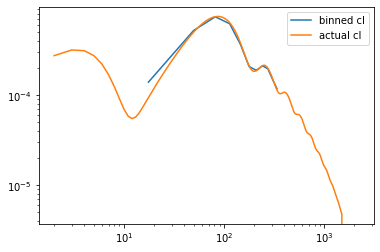

In [17]:
cl_th_binned = w_yp.decouple_cell(w_yp.couple_cell(cl_th))
plt.loglog(leff, cl_th_binned[3], label = 'binned cl')
plt.loglog(l, cl_th[3], label = 'actual cl')
plt.legend()

In [18]:
def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled

In [19]:
data_np = []
data_yp = []
for i in np.arange(nsim):
    #print(i, nsim)
    fnp, fyp = get_fields(i)
    data_np.append(compute_master(fnp, fnp, w_np))
    data_yp.append(compute_master(fyp, fyp, w_yp))
data_np = np.array(data_np)
data_yp = np.array(data_yp)

prefactor = leff*(leff+1)/2/np.pi
data_np *= prefactor
data_yp *= prefactor

clnp_mean = np.mean(data_np, axis=0)
clnp_std = np.std(data_np, axis=0)
clyp_mean = np.mean(data_yp, axis=0)
clyp_std = np.std(data_yp, axis=0)



/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


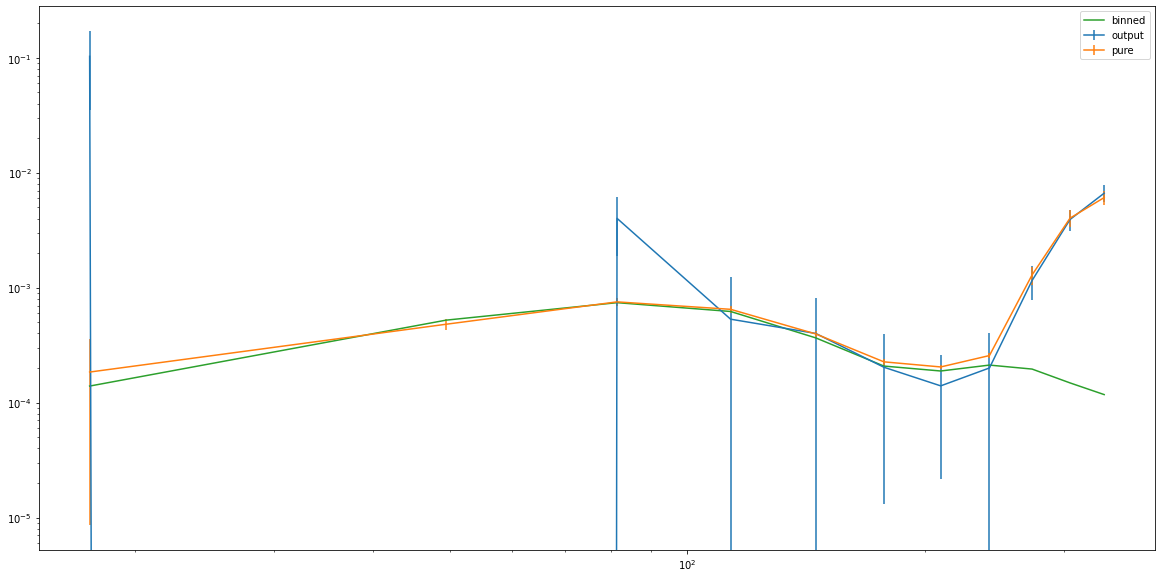

In [20]:
# Now we plot the results
plt.figure(figsize=(20,10))
plt.errorbar(leff, clnp_mean[3], yerr=clnp_std[3], label='output')
plt.errorbar(leff, clyp_mean[3], yerr=clyp_std[3], label='pure')
plt.plot(leff, cl_th_binned[3], label='binned')
plt.yscale('log')
plt.xscale('log')
plt.legend()